In [ ]:
!pip install pdf2image

In [ ]:
!apt-get install poppler-utils
from pdf2image import convert_from_path
from tqdm import tqdm

pages = convert_from_path("/content/Paredes - Reglas generales.pdf",
                          thread_count=4,
                          fmt='png',
                          poppler_path="/usr/bin")

for i in tqdm(range(len(pages)), desc="Converting pages"):
    pages[i].save(f"page_{i+1}.png", "PNG")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


Converting pages: 100%|██████████| 9/9 [01:16<00:00,  8.45s/it]


In [ ]:
import cv2
import albumentations as A
import os
from tqdm import tqdm  # Progress bar

# Initialize augmentations
transform = A.Compose([
    A.CLAHE(clip_limit=2.0, p=0.5),          # Improve contrast
    A.RandomGamma(gamma_limit=(70, 130), p=0.5),  # Fading effect
    A.GaussNoise(var_limit=(10, 30), p=0.5),       # Add noise
    A.ImageCompression(quality_lower=60, p=0.5),   # Simulate JPEG artifacts
])

def preprocess_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for img_name in tqdm(os.listdir(input_dir)):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Apply transformations
            augmented = transform(image=img)
            processed_img = augmented["image"]

            # Save with same name
            output_path = os.path.join(output_dir, img_name)
            cv2.imwrite(output_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))

# Usage
preprocess_images(
    input_dir=r"/content/drive/MyDrive/HUMAN_AI (1)/",
    output_dir=r"/content/drive/MyDrive/preprocess_imgs/"
)

PREPROCESSING


In [2]:
pip install opencv-python-headless numpy tqdm scikit-image albumentations

  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached albumentations-2.0.5-py3-none-any.whl.metadata (41 kB)
  Using cached tifffile-2025.3.30-py3-none-any.whl.metadata (32 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached pydantic-2.11.1-py3-none-any.whl.metadata (63 kB)
  Using cached albucore-0.0.23-py3-none-any.whl.metadata (5.3 kB)
  Using cached typing_inspection-0.4.0-py3-none-any.whl.metadata (2.6 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl (39.4 MB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.9 MB 2.4 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/12.9 MB 2.1 MB/s eta 0:00:06
   ---- ----------------------------------- 1.6/12.9 MB 1.9 MB/s eta 0:00:06
   ------ --------------------------------- 2.1/12.

In [3]:
pip install PyWavelets

   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.2 MB ? eta -:--:--
   -------------------------------- ------- 3.4/4.2 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 4.2/4.2 MB 12.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm  # For progress bar
from skimage.restoration import estimate_sigma, denoise_wavelet
import albumentations as A

# Document-Optimized Augmentation Pipeline
transform = A.Compose([
    A.CLAHE(clip_limit=1.5, tile_grid_size=(16, 16), p=1.0),
    A.RandomGamma(gamma_limit=(85, 115), p=0.4),
    A.GaussNoise(var_limit=(5, 15), p=0.3),
    A.Sharpen(alpha=(0.05, 0.1), lightness=(0.9, 1.0), p=0.5)
])

def process_single_image(input_path, output_path):
    
    try:
        # Read and validate image
        img = cv2.imread(input_path)
        if img is None:
            print(f"Warning: Could not read {input_path} - skipping")
            return False
        
        # Convert color space
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Apply transformations
        transformed = transform(image=img_rgb)
        processed = transformed["image"]
        
        # Conditional denoising
        if estimate_sigma(processed, channel_axis=-1)[0] > 10:
            processed = denoise_wavelet(processed, channel_axis=-1, rescale_sigma=True)
            processed = (255 * processed).clip(0, 255).astype(np.uint8)
        
        # Save result
        cv2.imwrite(output_path, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))
        return True
    
    except Exception as e:
        print(f"Error processing {input_path}: {str(e)}")
        return False

def batch_process_images(input_dir, output_dir):
    
    # Create output directory if needed
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all image files
    valid_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')
    image_files = [f for f in os.listdir(input_dir) 
                 if f.lower().endswith(valid_extensions)]
    
    if not image_files:
        print(f"No valid images found in {input_dir}")
        return
    
    # Process with progress bar
    success_count = 0
    with tqdm(total=len(image_files), desc="Processing images") as pbar:
        for img_name in image_files:
            input_path = os.path.join(input_dir, img_name)
            output_path = os.path.join(output_dir, img_name)
            
            if process_single_image(input_path, output_path):
                success_count += 1
            
            pbar.update(1)
    
    # Print summary
    print(f"\nProcessing complete. Success: {success_count}/{len(image_files)}")
    if success_count < len(image_files):
        print("Some images failed to process. Check warnings above.")

# Example Usage
input_directory = "HUMAN_AI/"
output_directory = "pre-process__200/"

batch_process_images(input_directory, output_directory)

C:\Users\manoj\AppData\Local\Temp\ipykernel_19196\3540215163.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 15), p=0.3),
Processing images:  19%|█▊        | 10/54 [02:22<10:28, 14.30s/it]


KeyboardInterrupt: 

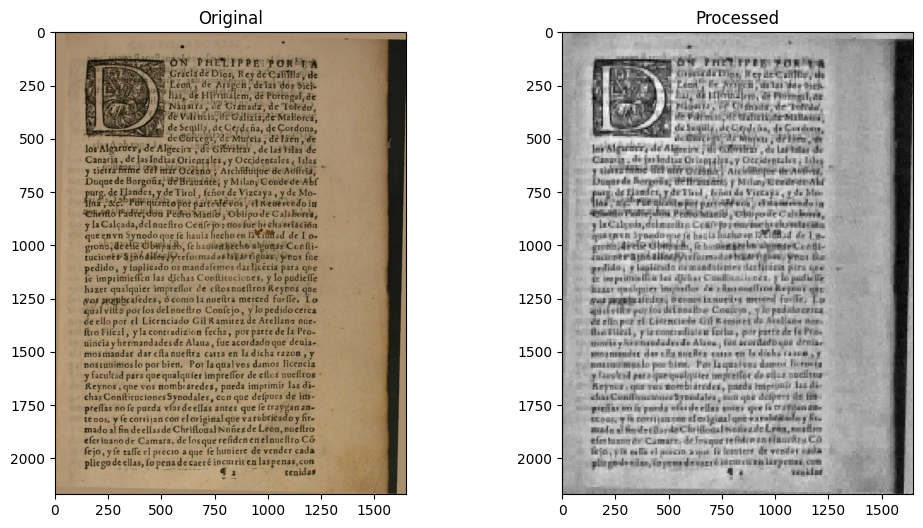

In [3]:
# %pip install matplotlib

import matplotlib.pyplot as plt

def compare_results(original_path, processed_path):
    original = cv2.imread(original_path)
    processed = cv2.imread(processed_path, 0)  # Read as grayscale
    
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.subplot(122), plt.imshow(processed, cmap='gray')
    plt.title("Processed")
    plt.show()

# Example usage
compare_results("HUMAN_AI\page_1 Constituciones.png", "pre-process__200\page_1 Constituciones.png")

In [4]:
import cv2
import numpy as np
import os
from tqdm import tqdm

def process_single_image(input_path, output_path):
    try:
        # Read Image
        img = cv2.imread(input_path)
        if img is None:
            print(f"Warning: Could not read {input_path} - skipping")
            return False

        # Convert to Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply Adaptive Thresholding
        processed = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 21, 10)

        # Denoising with Non-Local Means
        processed = cv2.fastNlMeansDenoising(processed, None, 30, 7, 21)

        # Sharpening using Unsharp Mask
        blurred = cv2.GaussianBlur(processed, (3, 3), 0)
        sharpened = cv2.addWeighted(processed, 1.5, blurred, -0.5, 0)

        # Save the processed image
        cv2.imwrite(output_path, sharpened)
        return True

    except Exception as e:
        print(f"Error processing {input_path}: {str(e)}")
        return False

def batch_process_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    valid_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(valid_extensions)]

    if not image_files:
        print(f"No valid images found in {input_dir}")
        return

    success_count = 0
    with tqdm(total=len(image_files), desc="Processing images") as pbar:
        for img_name in image_files:
            input_path = os.path.join(input_dir, img_name)
            output_path = os.path.join(output_dir, img_name)
            
            if process_single_image(input_path, output_path):
                success_count += 1
            
            pbar.update(1)
    
    print(f"\nProcessing complete. Success: {success_count}/{len(image_files)}")

# Example Usage
input_directory = "HUMAN_AI/"
output_directory = "pre-process__200/"

batch_process_images(input_directory, output_directory)


Processing images: 100%|██████████| 54/54 [30:17<00:00, 33.65s/it]


Processing complete. Success: 54/54


In [9]:
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm

input_dir = "HUMAN_AI/"
annotated_dir = "annotated_imgs/"
augmented_dir = "augmente_imgs/"

os.makedirs(annotated_dir, exist_ok=True)
os.makedirs(augmented_dir, exist_ok=True)

transform = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.GaussNoise(mean=0, p=0.3),  # Fixed: replaced var_limit with mean
    A.RandomGridShuffle(grid=(3, 3), p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, p=0.3)  # Fixed: removed alpha_affine
])

def augment_image(image_path, output_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed = transform(image=img_rgb)
    processed = transformed["image"]
    cv2.imwrite(output_path, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))

image_files = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]
for img_name in tqdm(image_files, desc="Processing Images"):
    img_path = os.path.join(input_dir, img_name)
    augment_image(img_path, os.path.join(augmented_dir, img_name))


C:\Users\manoj\AppData\Local\Temp\ipykernel_19196\3235136274.py:17: UserWarning: Argument(s) 'mean' are not valid for transform GaussNoise
  A.GaussNoise(mean=0, p=0.3),  # Fixed: replaced var_limit with mean
Processing Images: 0it [00:00, ?it/s]


In [11]:
# %pip install labelme

import os
import cv2
import numpy as np
import albumentations as A
from labelme import LabelFile
from tqdm import tqdm

input_dir = "HUMAN_AI/"
annotated_dir = "annotated_imgs/"
augmented_dir = "augmente_imgs/"

os.makedirs(annotated_dir, exist_ok=True)
os.makedirs(augmented_dir, exist_ok=True)

transform = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.GaussNoise(var_limit=(10, 50), p=0.3),
    A.RandomGridShuffle(grid=(3, 3), p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3)
])

def annotate_image(image_path, output_path):
    label_data = {
        "version": "4.5.6",
        "flags": {},
        "shapes": [
            {"label": "main_text", "points": [[100, 100], [800, 100], [800, 1200], [100, 1200]], "group_id": None, "shape_type": "polygon", "flags": {}}
        ],
        "imagePath": os.path.basename(image_path),
        "imageData": None,
        "imageHeight": None,
        "imageWidth": None
    }
    with open(output_path, "w") as f:
        f.write(str(label_data))

def augment_image(image_path, output_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed = transform(image=img_rgb)
    processed = transformed["image"]
    cv2.imwrite(output_path, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))

image_files = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]
for img_name in tqdm(image_files, desc="Processing Images"):
    img_path = os.path.join(input_dir, img_name)
    annotate_image(img_path, os.path.join(annotated_dir, img_name.replace(".jpg", ".json")))
    augment_image(img_path, os.path.join(augmented_dir, img_name))


C:\Users\manoj\AppData\Local\Temp\ipykernel_19196\1563107362.py:20: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.3),
C:\Users\manoj\AppData\Local\Temp\ipykernel_19196\1563107362.py:22: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3)
Processing Images: 0it [00:00, ?it/s]


In [2]:
import cv2
import numpy as np
import os

input_dir = "pre-process__200/"
annotated_dir = "annotations/"
os.makedirs(annotated_dir, exist_ok=True)

def detect_text_regions(image_path, output_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(thresh, kernel, iterations=2)
    
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_color = cv2.imread(image_path)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if h > 20:  # Ignore small noise
            cv2.rectangle(img_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.imwrite(output_path, img_color)

image_files = [f for f in os.listdir(input_dir) if f.endswith(".png")]
for img_name in image_files:
    detect_text_regions(os.path.join(input_dir, img_name), os.path.join(annotated_dir, img_name))


SUPER-RESOLUTION AND DENOISING


In [2]:
!pip install transformers datasets torch torchvision


  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
  Using cached torchvision-0.21.0-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
Using cached datasets-3.5.0-py3-none-any.whl (491 kB)
Using cached torchvision-0.21.0-cp311-cp311-win_amd64.whl (1.6 MB)


In [4]:
pip install pytesseract

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Processor
# from PIL import Image
# import torch

# model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base")
# processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")

# folder_path = r"annotations/"


# for images in folder_path:
#     image_path = os.path.join(folder_path, images)
#     image = Image.open(image_path).convert("RGB")

#     encoding = processor(image, return_tensors="pt")
#     outputs = model(**encoding)
#     predictions = torch.argmax(outputs.logits, dim=-1)

#     print("Predicted layout labels:", predictions)
# # image_path = r"annotations\page_1 (1).png"
# # image = Image.open(image_path).convert("RGB")

# # encoding = processor(image, return_tensors="pt")
# # outputs = model(**encoding)
# # predictions = torch.argmax(outputs.logits, dim=-1)

# # print("Predicted layout labels:", predictions)


d:\GSOC_2025\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\GSOC_2025\.conda\Lib\site-packages\transformers\modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Predicted layout labels: tensor([[1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
         1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
         0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]])


In [2]:
import os
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Processor
from PIL import Image
import torch
import json

# Load model and processor
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")

# Folder with annotated images
folder_path = r"annotations/"
output_folder = r"predictions/"
os.makedirs(output_folder, exist_ok=True)

# Process all image files in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(".png"):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path).convert("RGB")

        # Tokenize and predict
        encoding = processor(image, return_tensors="pt")
        outputs = model(**encoding)
        predictions = torch.argmax(outputs.logits, dim=-1)[0].tolist()  

        # Save predictions to JSON
        save_path = os.path.join(output_folder, filename.replace(".jpg", ".json").replace(".png", ".json"))
        with open(save_path, "w") as f:
            json.dump({"filename": filename, "predicted_labels": predictions}, f)

        print(f"Processed: {filename}")


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\GSOC_2025\.conda\Lib\site-packages\transformers\modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Processed: page_1 (1).png
Processed: page_1 (2).png
Processed: page_1 (3).png
Processed: page_1 (4).png


Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


IndexError: index out of range in self

In [3]:
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
import torchvision.transforms as T

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")

image_path = r"annotations\page_2 (1).png"  # your full annotated page
image = Image.open(image_path).convert("RGB")

# Slide vertically over the image
height = image.height
window_size = 1024
stride = 512

all_predictions = []

for top in range(0, height, stride):
    box = (0, top, image.width, min(top + window_size, height))
    cropped = image.crop(box)

    encoding = processor(cropped, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**encoding)
    predictions = torch.argmax(outputs.logits, dim=-1)

    all_predictions.append(predictions)

print("Full page token predictions stitched across windows!")


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\GSOC_2025\.conda\Lib\site-packages\transformers\modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Full page token predictions stitched across windows!


In [5]:
import os
import json
from PIL import Image
import torch
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Processor

# Load model and processor
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")

# Set model to eval mode
model.eval()

# Folder containing annotated images
folder_path = r"annotations/"
output_folder = r"Output_files/"
os.makedirs(output_folder, exist_ok=True)

# Sliding window parameters
max_length = 512

# Iterate through all images in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path).convert("RGB")
        print(f"Processing: {filename}")

        # Encode full image
        encoding = processor(image, return_tensors="pt", truncation=False)

        # Get input_ids and attention mask
        input_ids = encoding["input_ids"][0]  # shape: [num_tokens]
        attention_mask = encoding["attention_mask"][0]

        # Apply sliding window
        predictions = []
        for i in range(0, input_ids.size(0), max_length):
            input_chunk = input_ids[i:i+max_length].unsqueeze(0)  # add batch dim
            attn_chunk = attention_mask[i:i+max_length].unsqueeze(0)

            chunk_outputs = model(input_ids=input_chunk, attention_mask=attn_chunk)
            chunk_preds = torch.argmax(chunk_outputs.logits, dim=-1)
            predictions.append(chunk_preds.squeeze(0))  # remove batch dim

        # Combine all predictions
        final_preds = torch.cat(predictions, dim=0)

        # Save predictions as JSON
        output_labels = final_preds.tolist()
        out_filename = os.path.splitext(filename)[0] + ".json"
        out_path = os.path.join(output_folder, out_filename)
        with open(out_path, "w") as f:
            json.dump(output_labels, f)

        print(f"Saved predictions to {out_filename}")


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing: page_1 (1).png


d:\GSOC_2025\.conda\Lib\site-packages\transformers\modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Saved predictions to page_1 (1).json
Processing: page_1 (2).png
Saved predictions to page_1 (2).json
Processing: page_1 (3).png
Saved predictions to page_1 (3).json
Processing: page_1 (4).png
Saved predictions to page_1 (4).json
Processing: page_1 Constituciones.png


Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


Saved predictions to page_1 Constituciones.json


d:\GSOC_2025\.conda\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (94080000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing: page_1.png
Saved predictions to page_1.json
Processing: page_10.png
Saved predictions to page_10.json
Processing: page_11 (1).png
Saved predictions to page_11 (1).json
Processing: page_11.png
Saved predictions to page_11.json
Processing: page_12.png
Saved predictions to page_12.json
Processing: page_13.png
Saved predictions to page_13.json
Processing: page_14.png
Saved predictions to page_14.json
Processing: page_15.png
Saved predictions to page_15.json
Processing: page_16.png
Saved predictions to page_16.json
Processing: page_2 (1).png
Saved predictions to page_2 (1).json
Processing: page_2 (2).png
Saved predictions to page_2 (2).json
Processing: page_2 (3).png
Saved predictions to page_2 (3).json
Processing: page_2 (4).png
Saved predictions to page_2 (4).json
Processing: page_2 Constitutiones.png
Saved predictions to page_2 Constitutiones.json
Processing: page_2.png
Saved predictions to page_2.json
Processing: page_3 (1).png
Saved predictions to page_3 (1).json
Processing

In [4]:
print(all_predictions
      )

[tensor([[0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
         1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]), tensor([[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
         0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
         0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
         0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
         1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0]]), tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 

In [5]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'D:\Tesseract-OCR\tesseract.exe'

In [3]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [1]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class LayoutDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, label_map, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.label_map = label_map
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        annotation_path = os.path.join(self.annotation_dir, image_name.replace('.png', '.json').replace('.jpg', '.json'))

        image = Image.open(image_path).convert("RGB")
        width, height = image.size

        # Load annotations
        with open(annotation_path, 'r') as f:
            data = json.load(f)

        boxes = []
        labels = []

        for item in data["annotations"]:
            x, y, w, h = item["bbox"]
            label_name = item["label"]
            label = self.label_map.get(label_name, 0)

            boxes.append([x, y, x + w, y + h])
            labels.append(label)

        # Convert to tensors
        if self.transform:
            image = self.transform(image)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }

        return image, target


In [ ]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

class LayoutDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, label_map, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.label_map = label_map
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        image = Image.open(img_path).convert("RGB")

        ann_path = os.path.join(self.annotation_dir, os.path.splitext(img_filename)[0] + ".json")
        with open(ann_path, 'r') as f:
            annotations = json.load(f)

        boxes = []
        labels = []
        for ann in annotations['annotations']:
            bbox = ann['bbox']  # [x, y, width, height]
            label = ann['label']
            if label in self.label_map:
                boxes.append(bbox)
                labels.append(self.label_map[label])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            image = self.transform(image)

        return image, target

# Define label map and transformations
label_map = {"text": 1, "embellishment": 0}
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Paths to folders
image_folder = "annotations/"
annotation_folder = "Output_files/"

# Create dataset and dataloader
dataset = LayoutDataset(image_folder, annotation_folder, label_map, transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


LayoutLMv3 Model Training

In [9]:
import json
import os

output_folder = "Output_files/"
os.makedirs(output_folder, exist_ok=True)

for i, (filename, boxes_tensor, labels_tensor) in enumerate(zip(image_filenames, all_boxes, all_labels)):
    output = {
        "annotations": [
            {"bbox": box.tolist(), "label": "text" if label == 1 else "embellishment"}
            for box, label in zip(boxes_tensor, labels_tensor)
        ]
    }
    base_name = os.path.splitext(filename)[0]
    with open(os.path.join(output_folder, base_name + ".json"), "w") as f:
        json.dump(output, f, indent=2)


NameError: name 'image_filenames' is not defined

In [8]:
import os
import torch
from torch.utils.data import DataLoader
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Processor
from torch.optim import AdamW 
from transformers import get_scheduler
from tqdm import tqdm
from datasett import LayoutDataset

label_map = {
    "background": 0,
    "text": 1
}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load processor and model
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=2
)
model.to(device)

# Dataset and Dataloader
train_dataset = LayoutDataset("D:\GSOC_2025\Output_files/", processor,label_map, transform=None)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 5
num_training_steps = epochs * len(train_loader)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Training Loop
model.train()
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc="Training")

    for batch in progress_bar:
        for k in batch:
            batch[k] = batch[k].to(device)

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    print(f"Epoch {epoch+1} Loss: {epoch_loss/len(train_loader):.4f}")

# Save model
model.save_pretrained("layoutlmv3-finetuned")
processor.save_pretrained("layoutlmv3-finetuned")


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: num_samples should be a positive integer value, but got num_samples=0